In [1]:
pip install yfinance pandas numpy matplotlib seaborn xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [60]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import yfinance as yf
from pandas_datareader import data as pdr
import datetime
from statsmodels.tsa.stattools import adfuller
import seaborn as sns





In [5]:
# Fetch S&P 500 data
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

df = yf.download('^GSPC', start= start_date, end= end_date)
# Display the first few rows of the DataFrame
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


In [6]:
df.shape

(3522, 5)

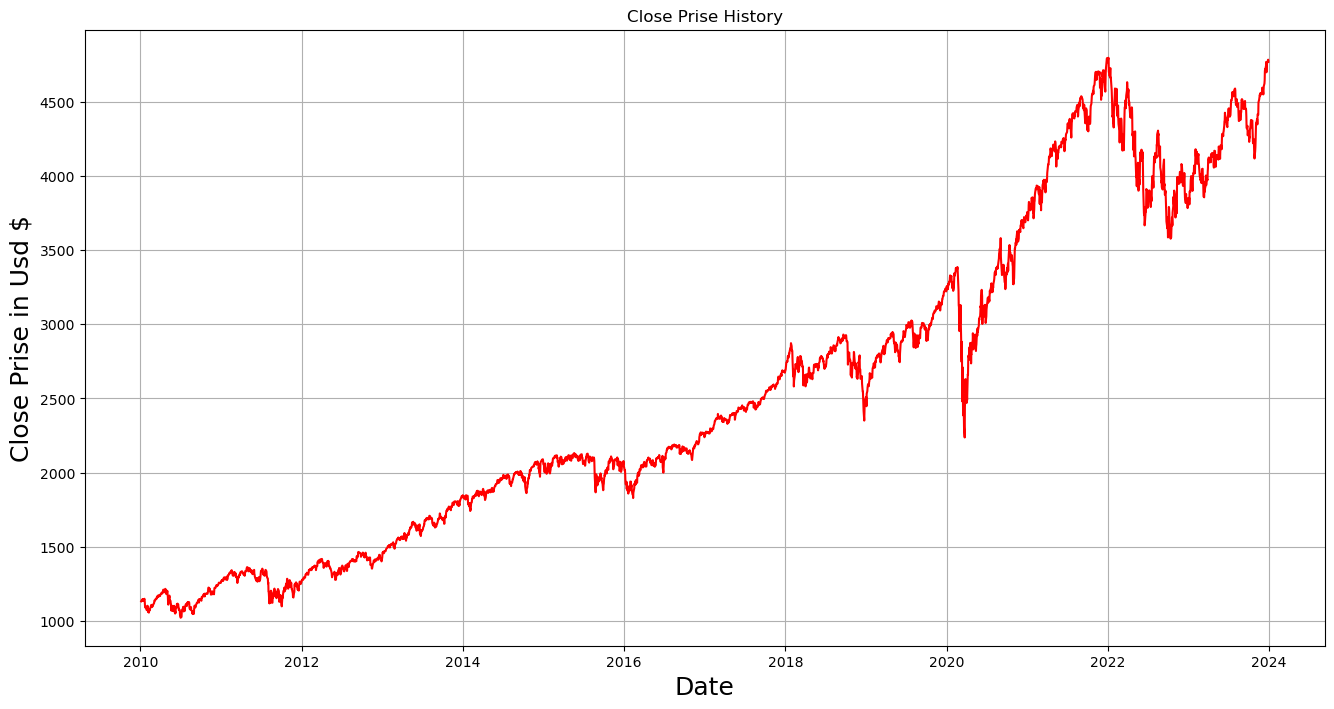

In [7]:
# Visualisation des prix de fermeture
plt.figure(figsize = (16,8))
plt.title('Close Prise History')
plt.plot(df['Close'], color = 'r')
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Prise in Usd $", fontsize = 18)
plt.grid()
plt.show()

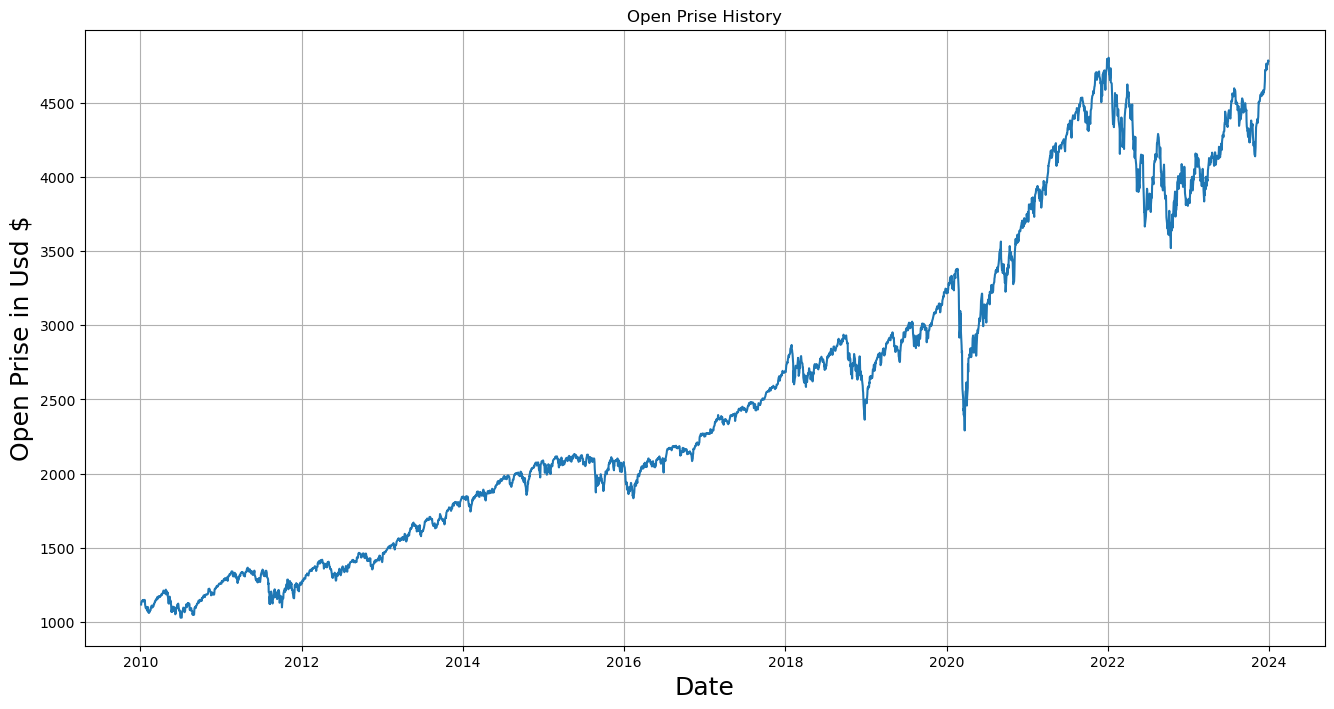

In [8]:
# Visualisation des prix d'ouverture
plt.figure(figsize = (16,8))
plt.title('Open Prise History')
plt.plot(df['Open'])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Open Prise in Usd $", fontsize = 18)
plt.grid()
plt.show()

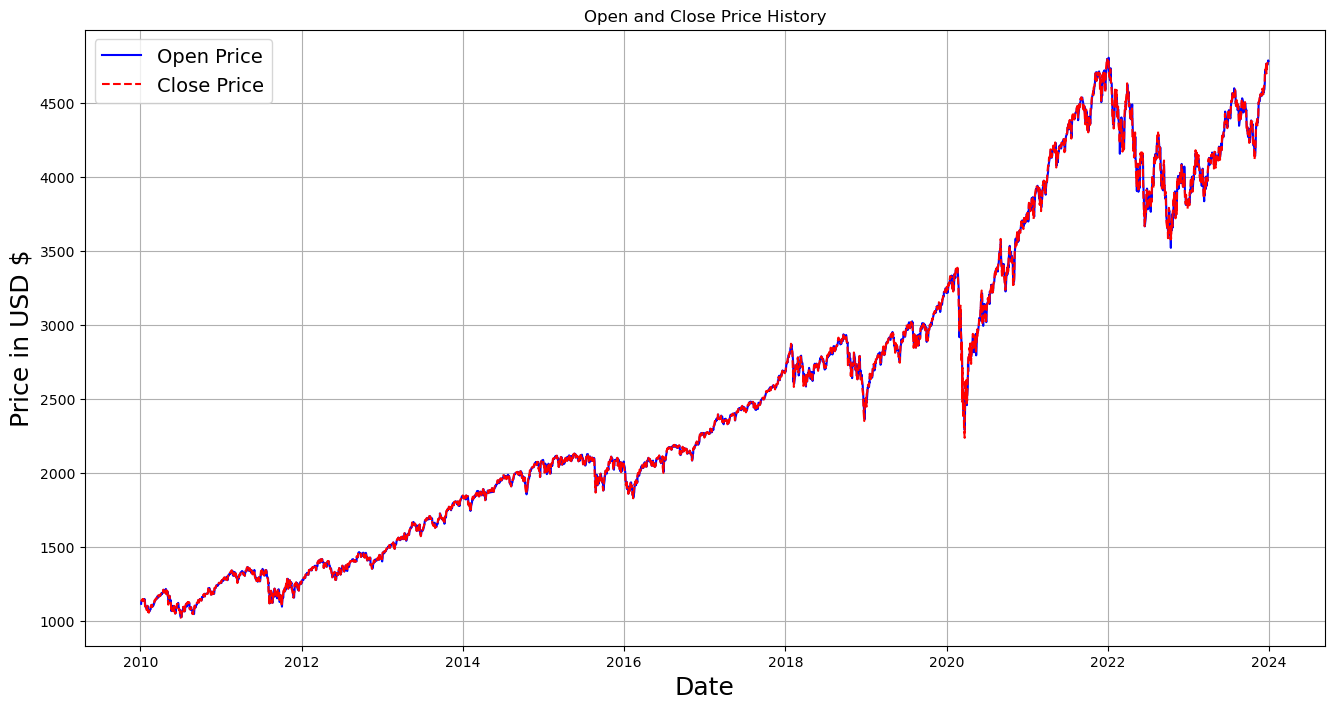

In [9]:
# Visualisation des prix d'ouverture et de clôture sur le même graphique
plt.figure(figsize=(16, 8))
plt.title('Open and Close Price History')
plt.plot(df['Open'], label='Open Price', color='blue')  # Courbe bleue pour les prix d'ouverture
plt.plot(df['Close'], label='Close Price', linestyle = '--', color='red')  # Courbe rouge pour les prix de clôture
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price in USD $", fontsize=18)
plt.legend(fontsize=14)  # Ajoute une légende pour différencier les courbes
plt.grid()
plt.show()


## Remarque : 

- Il manque certaines lignes dans les prix qui correspondent aux jours de fermeture de la bourse : week end et jours fériés 

## Import des variables exogènes 

Attention à ne pas run deux fois sinon les colonnes deviennent NaN, je ne sais pas pourquoi

In [12]:
# VIX (Indice de volatilité)
vix_data = yf.download("^VIX", start=start_date, end=end_date)

vix_data_daily = vix_data.reindex(df.index, method='ffill')

print(vix_data_daily.head(20))

#Ajouter le VIX aux données du S&P 500
df['VIX'] = vix_data_daily['Close']
df['VIX_diff'] = df['VIX'].diff()

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open Volume
Ticker           ^VIX       ^VIX       ^VIX       ^VIX   ^VIX
Date                                                         
2010-01-04  20.040001  21.680000  20.030001  21.680000      0
2010-01-05  19.350000  20.129999  19.340000  20.049999      0
2010-01-06  19.160000  19.680000  18.770000  19.590000      0
2010-01-07  19.059999  19.709999  18.700001  19.680000      0
2010-01-08  18.129999  19.270000  18.110001  19.270000      0
2010-01-11  17.549999  17.740000  16.860001  16.930000      0
2010-01-12  18.250000  19.459999  17.950001  17.950001      0
2010-01-13  17.850000  18.719999  17.559999  17.940001      0
2010-01-14  17.629999  18.270000  17.379999  18.160000      0
2010-01-15  17.910000  19.020000  17.629999  17.629999      0
2010-01-19  17.580000  18.850000  17.330000  18.629999      0
2010-01-20  18.680000  19.690001  18.440001  18.510000      0
2010-01-21  22.270000  22.299999  18.270000  18.590000      0
2010-01-

In [13]:
# Taux d'intérêt 

# Récupérer les taux des obligations à 10 ans
treasury_yield_10y = pdr.get_data_fred('DGS10', start_date, end_date)

treasury_yield_daily = treasury_yield_10y.reindex(df.index, method='ffill')

df['Treasury_Yield_10y'] = treasury_yield_daily

# Afficher les premières lignes
print(treasury_yield_daily.head())
df['Treasury_Yield_10y_diff'] = df['Treasury_Yield_10y'].diff()

            DGS10
Date             
2010-01-04   3.85
2010-01-05   3.77
2010-01-06   3.85
2010-01-07   3.85
2010-01-08   3.83


In [14]:
# Taux de chômage

'''
#une solution pour eviter d'avoir le problème lorsque l'on lance deux fois 

if 'Unemployment_Rate' in df.columns:
    df.drop(columns=['Unemployment_Rate'], inplace=True)
'''
unemployment_rate = pdr.get_data_fred('UNRATE', start_date, end_date)
unemployment_rate_daily = unemployment_rate.reindex(df.index, method='ffill')
df['Unemployment_Rate'] = unemployment_rate_daily

print(unemployment_rate_daily.head())

# Si Unemployment_Rate change tous les 60 jours, calcule la variation par rapport à la valeur précédente.
df['Unemployment_Rate_diff'] = df['Unemployment_Rate'].diff(periods=60)

            UNRATE
Date              
2010-01-04     9.8
2010-01-05     9.8
2010-01-06     9.8
2010-01-07     9.8
2010-01-08     9.8


In [15]:
# Indice sur l'inflation

cpi = pdr.get_data_fred('CPIAUCSL', start_date, end_date)
cpi_daily = cpi.reindex(df.index, method='ffill')
df['CPI'] = cpi_daily

print(cpi_daily.head())

# Si CPI change tous les 20 jours, calcule la variation par rapport à la valeur précédente.
df['CPI_diff'] = df['CPI'].diff(periods=20)

            CPIAUCSL
Date                
2010-01-04   217.488
2010-01-05   217.488
2010-01-06   217.488
2010-01-07   217.488
2010-01-08   217.488


In [16]:
df

Price,Close,High,Low,Open,Volume,VIX,VIX_diff,Treasury_Yield_10y,Treasury_Yield_10y_diff,Unemployment_Rate,Unemployment_Rate_diff,CPI,CPI_diff
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,,,
Date,,,,,,,,,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000,20.040001,NaN,3.85,NaN,9.8,NaN,217.488,NaN
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,19.350000,-0.690001,3.77,-0.08,9.8,NaN,217.488,NaN
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,19.160000,-0.190001,3.85,0.08,9.8,NaN,217.488,NaN
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,19.059999,-0.100000,3.85,0.00,9.8,NaN,217.488,NaN
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,18.129999,-0.930000,3.83,-0.02,9.8,NaN,217.488,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000,13.030000,-0.620000,3.90,0.01,3.7,-0.1,308.742,0.718
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000,12.990000,-0.040000,3.89,-0.01,3.7,-0.1,308.742,0.718


## Ajout d'une colonne 'Close J+1' et rendement logarithmique

Cela sera notre colonne de vérification, si notre modèle nous donne de bons résultats

In [18]:
if 'Close J+1' in df.columns:
    df.drop(columns=['Close J+1'], inplace=True)

df['Close J+1']= df['Close'].shift(-1)

In [19]:
# Rendement log, R = log(Xt+1) - log(Xt) = log(Xt+1 / Xt)

if 'Log_Returns' in df.columns : 
    df.drop(columns=['Log_Returns'], inplace = True)

df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))


In [20]:
df

Price,Close,High,Low,Open,Volume,VIX,VIX_diff,Treasury_Yield_10y,Treasury_Yield_10y_diff,Unemployment_Rate,Unemployment_Rate_diff,CPI,CPI_diff,Close J+1,Log_Returns
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000,20.040001,NaN,3.85,NaN,9.8,NaN,217.488,NaN,1136.520020,NaN
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,19.350000,-0.690001,3.77,-0.08,9.8,NaN,217.488,NaN,1137.140015,0.003111
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,19.160000,-0.190001,3.85,0.08,9.8,NaN,217.488,NaN,1141.689941,0.000545
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,19.059999,-0.100000,3.85,0.00,9.8,NaN,217.488,NaN,1144.979980,0.003993
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,18.129999,-0.930000,3.83,-0.02,9.8,NaN,217.488,NaN,1146.979980,0.002878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,4772.939941,4736.770020,4753.919922,3046770000,13.030000,-0.620000,3.90,0.01,3.7,-0.1,308.742,0.718,4774.750000,0.001659
2023-12-26,4774.750000,4784.720215,4758.450195,4758.859863,2513910000,12.990000,-0.040000,3.89,-0.01,3.7,-0.1,308.742,0.718,4781.580078,0.004223


## Vérification de la qualité de la data

In [22]:
df.isna().sum()

Price                    Ticker
Close                    ^GSPC      0
High                     ^GSPC      0
Low                      ^GSPC      0
Open                     ^GSPC      0
Volume                   ^GSPC      0
VIX                                 0
VIX_diff                            1
Treasury_Yield_10y                 26
Treasury_Yield_10y_diff            53
Unemployment_Rate                   0
Unemployment_Rate_diff             60
CPI                                 0
CPI_diff                           20
Close J+1                           1
Log_Returns                         1
dtype: int64

In [23]:
df.isnull().sum()

Price                    Ticker
Close                    ^GSPC      0
High                     ^GSPC      0
Low                      ^GSPC      0
Open                     ^GSPC      0
Volume                   ^GSPC      0
VIX                                 0
VIX_diff                            1
Treasury_Yield_10y                 26
Treasury_Yield_10y_diff            53
Unemployment_Rate                   0
Unemployment_Rate_diff             60
CPI                                 0
CPI_diff                           20
Close J+1                           1
Log_Returns                         1
dtype: int64

In [24]:
null_dates_treasury = df[df['Treasury_Yield_10y'].isnull()].index
print(null_dates_treasury)

DatetimeIndex(['2010-10-11', '2010-11-11', '2011-10-10', '2011-11-11',
               '2012-10-08', '2012-11-12', '2013-10-14', '2013-11-11',
               '2014-10-13', '2014-11-11', '2015-10-12', '2015-11-11',
               '2016-10-10', '2016-11-11', '2017-10-09', '2018-10-08',
               '2018-11-12', '2019-10-14', '2019-11-11', '2020-10-12',
               '2020-11-11', '2021-10-11', '2021-11-11', '2022-10-10',
               '2022-11-11', '2023-10-09'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [25]:
# Supprimer le niveau 'Ticker' pour ne conserver que 'Price', supprimer le multi index
df.columns = df.columns.get_level_values(0)

In [26]:
# Correction des valeurs NaN pour la colonne treasury 

df['Treasury_Yield_10y']=df['Treasury_Yield_10y'].interpolate(method='linear')

# Suppresion de la dernière ligne - colonne avec la valeur Na dans close 

if 'Close' in df.columns:
    df.dropna(subset=['Close'], inplace=True)
else:
    print("Colonne 'Close' manquante dans le DataFrame.")

# Suppresion de la première ligne - colonne avec la valeur Na dans Log-returns 

if 'Log_Returns' in df.columns:
    df.dropna(subset=['Log_Returns'], inplace=True)
else:
    print("Colonne 'Log_Returns' manquante dans le DataFrame.")

# Suppresion de la dernière ligne - colonne avec la valeur Na dans Close J+1 

if 'Close J+1' in df.columns:
    df.dropna(subset=['Close J+1'], inplace=True)
else:
    print("Colonne 'Close J+1' manquante dans le DataFrame.")

In [27]:
diff_columns = ['VIX_diff', 'Treasury_Yield_10y_diff', 'CPI_diff', 'Unemployment_Rate_diff']
# Remplacer les NaN par une valeur (par exemple 0) dans les colonnes *_diff
df[diff_columns] = df[diff_columns].fillna(0)

# Vérifier à nouveau les valeurs manquantes
print(df.isna().sum())


Price
Close                      0
High                       0
Low                        0
Open                       0
Volume                     0
VIX                        0
VIX_diff                   0
Treasury_Yield_10y         0
Treasury_Yield_10y_diff    0
Unemployment_Rate          0
Unemployment_Rate_diff     0
CPI                        0
CPI_diff                   0
Close J+1                  0
Log_Returns                0
dtype: int64


In [28]:
# Vérification des corrections

df.isnull().sum()

Price
Close                      0
High                       0
Low                        0
Open                       0
Volume                     0
VIX                        0
VIX_diff                   0
Treasury_Yield_10y         0
Treasury_Yield_10y_diff    0
Unemployment_Rate          0
Unemployment_Rate_diff     0
CPI                        0
CPI_diff                   0
Close J+1                  0
Log_Returns                0
dtype: int64

## Analyse de la stationnarité


In [30]:
# Test ADF
result = adfuller(df['Log_Returns'])

print("Statistique de test ADF :", result[0])
print("P-value :", result[1])
print("Valeurs critiques :", result[4])

Statistique de test ADF : -12.900083680696982
P-value : 4.266429641242552e-24
Valeurs critiques : {'1%': -3.432223493307061, '5%': -2.8623678028686657, '10%': -2.567210653930658}


Comme la p-value est inférieur à 0.05, l'hypothèse nulle est rejetée donc le processus est stationnaire par rapport au rendement logarithmique

In [32]:
# Test ADF
result_close = adfuller(df['Close'])

print("Statistique de test ADF :", result_close[0])
print("P-value :", result_close[1])
print("Valeurs critiques :", result_close[4])

Statistique de test ADF : 0.2701557293697906
P-value : 0.9759330457566546
Valeurs critiques : {'1%': -3.432225642776137, '5%': -2.8623687523122516, '10%': -2.5672111593871447}


Le processus (close) a une p-value largement supérieur à 0.05. Le processus a donc une racine unitaire et n'est donc pas stationnaire. On ne pourra pas appliquer des modèles ARIMA. 

## Feature Engineering

Création d'indicateurs financiers : 
- RSI : la temporalité des données ne compte pas, c'est la séquence donc on n'est pas obligé de régulariser les données (c'est à dire faire attention au jour par jour). 
RSI = 100 - (100 / (1 + (hausse moyenne / baisse moyenne))
RSI > 70 : Vendre
RSI < 30 : Acheter
- MA
- 

In [35]:
# RSI

def calculate_rsi(data, window=14):

    delta = data.diff()  # Calcul des différences entre les lignes

    # 2. Séparer les gains et les pertes
    gain = delta.where(delta > 0, 0)  # Gains positifs
    loss = -delta.where(delta < 0, 0)  # Pertes positives (converties en valeurs absolues)

    # 3. Moyenne mobile exponentielle des gains et pertes
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # 4. Calcul du RS (Relative Strength)
    rs = avg_gain / avg_loss

    # 5. Calcul du RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

rsi_7 = calculate_rsi( df['Close'], 7 )
rsi_14 = calculate_rsi( df['Close'], 14 )
rsi_21 = calculate_rsi( df['Close'], 21 )

df['RSI_7'] = rsi_7
df['RSI_14'] = rsi_14
df['RSI_21'] = rsi_21

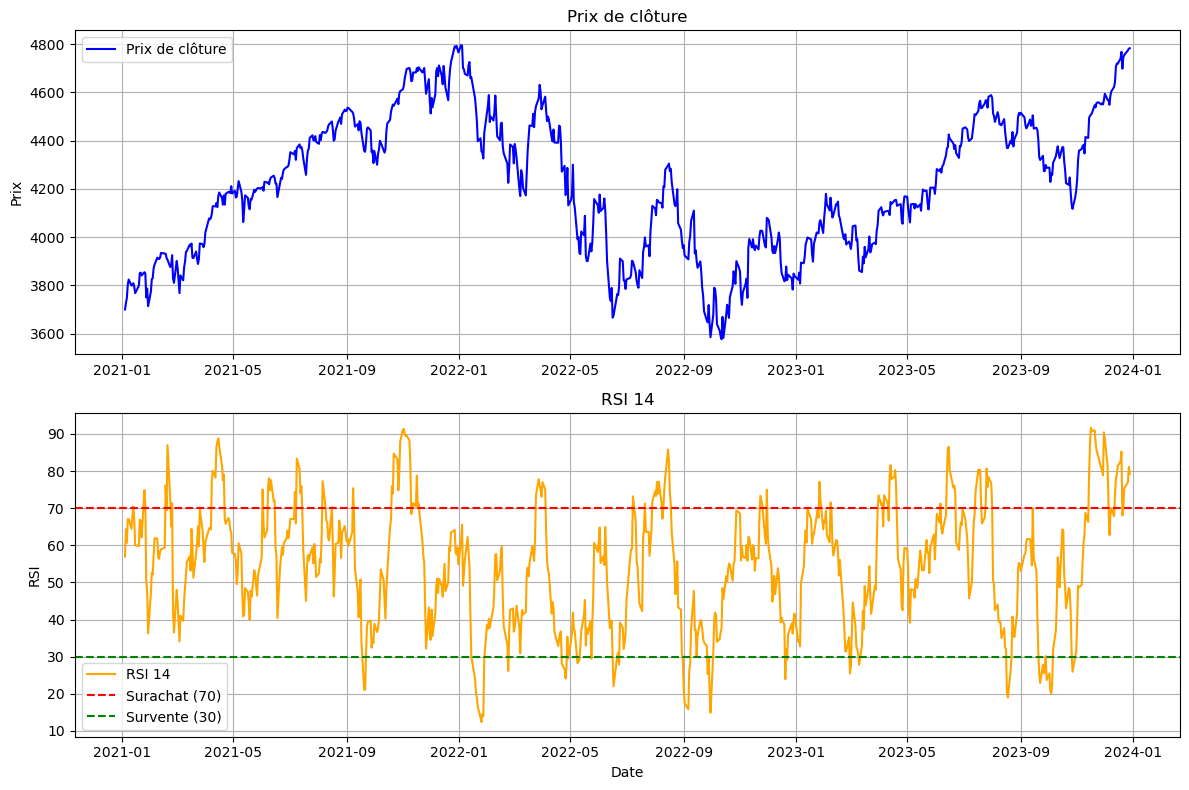

In [36]:
# Créer la figure et les sous-graphiques (axes)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Choisir sur quelle fenêtre tracer le graphique 
df_filtered = df.loc['2021-01-01':'2023-12-31']

# Graphique 1 : Prix de clôture
ax[0].plot(df_filtered.index, df_filtered['Close'], label='Prix de clôture', color='blue')
ax[0].set_title('Prix de clôture')
ax[0].set_ylabel('Prix')
ax[0].grid()
ax[0].legend()

# Graphique 2 : RSI 14
ax[1].plot(df_filtered.index, df_filtered['RSI_14'], label='RSI 14', color='orange')
ax[1].axhline(70, color='red', linestyle='--', label='Surachat (70)')
ax[1].axhline(30, color='green', linestyle='--', label='Survente (30)')
ax[1].set_title('RSI 14')
ax[1].set_ylabel('RSI')
ax[1].set_xlabel('Date')
ax[1].grid()
ax[1].legend()

# Ajuster l'espace entre les graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()



In [37]:
# Moyenne mobile --> les plus utiliser : 5, 10, 20, 50, 200

def moyenne_mobile(data, window):
    return data.rolling(window=window).mean()


df['MA_5'] = moyenne_mobile(df['Close'], 5)
df['MA_10'] = moyenne_mobile(df['Close'], 10)
df['MA_20'] = moyenne_mobile(df['Close'], 20)
df['MA_50'] = moyenne_mobile(df['Close'], 50)
df['MA_200'] = moyenne_mobile(df['Close'], 200)

#on regarde l'évolution des moyennes mobiles
df['Close_vs_MA_5'] = df['Close'] - df['MA_5']
df['Close_vs_MA_10'] = df['Close'] - df['MA_10']
df['Close_vs_MA_20'] = df['Close'] - df['MA_20']
df['Close_vs_MA_50'] = df['Close'] - df['MA_50']
df['Close_vs_MA_200'] = df['Close'] - df['MA_200']

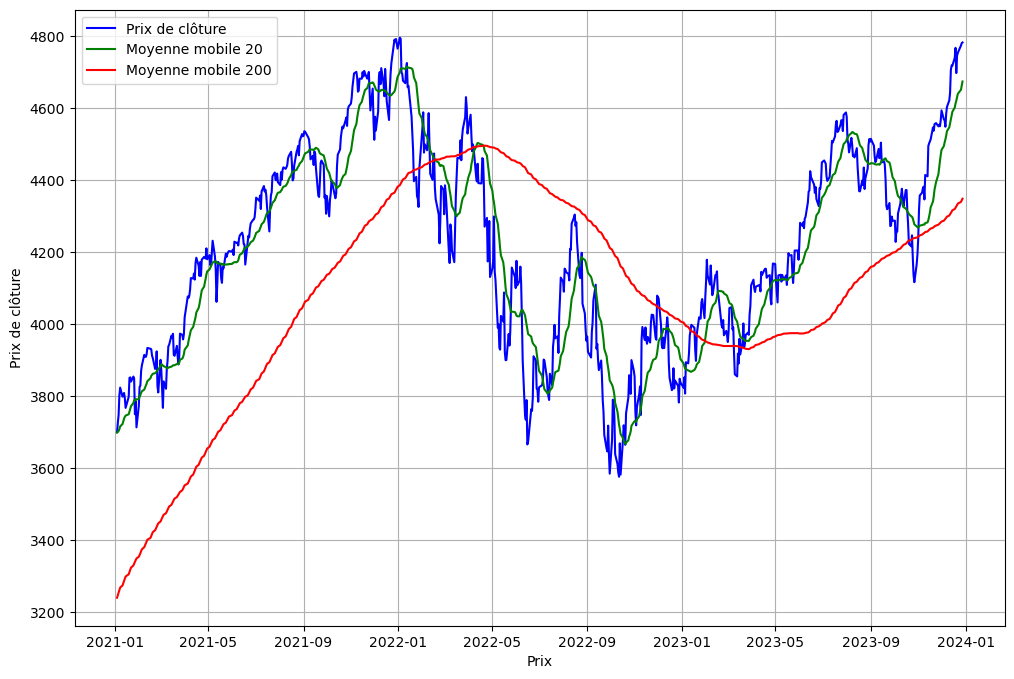

In [38]:
# Choisir sur quelle fenêtre tracer le graphique 
df_filtered = df.loc['2021-01-01':'2023-12-31']

plt.figure(figsize=(12, 8))

plt.plot(df_filtered.index, df_filtered['Close'], label='Prix de clôture', color='blue')
plt.plot(df_filtered.index, df_filtered['MA_20'], label='Moyenne mobile 20', color='green')
plt.plot(df_filtered.index, df_filtered['MA_200'], label='Moyenne mobile 200', color='red')


plt.ylabel('Prix de clôture')
plt.xlabel('Prix')
plt.grid()
plt.legend()

# Afficher le graphique
plt.show()



In [39]:
# Exponentielle moving average : les plus utiliser : 5, 9, 21, 50  

def calculate_ema(data, span):
    return data.ewm(span=span, adjust=False).mean()

df['EMA_5'] = calculate_ema(df['Close'], 5)
df['EMA_9'] = calculate_ema(df['Close'], 9)
df['EMA_21'] = calculate_ema(df['Close'], 21)
df['EMA_50'] = calculate_ema(df['Close'], 50)

df['EMA_9_21_diff'] = df['EMA_9'] - df['EMA_21']
df['EMA_9_cross_21'] = (df['EMA_9'] > df['EMA_21']).astype(int)  # 1 si EMA_9 > EMA_21, sinon 0

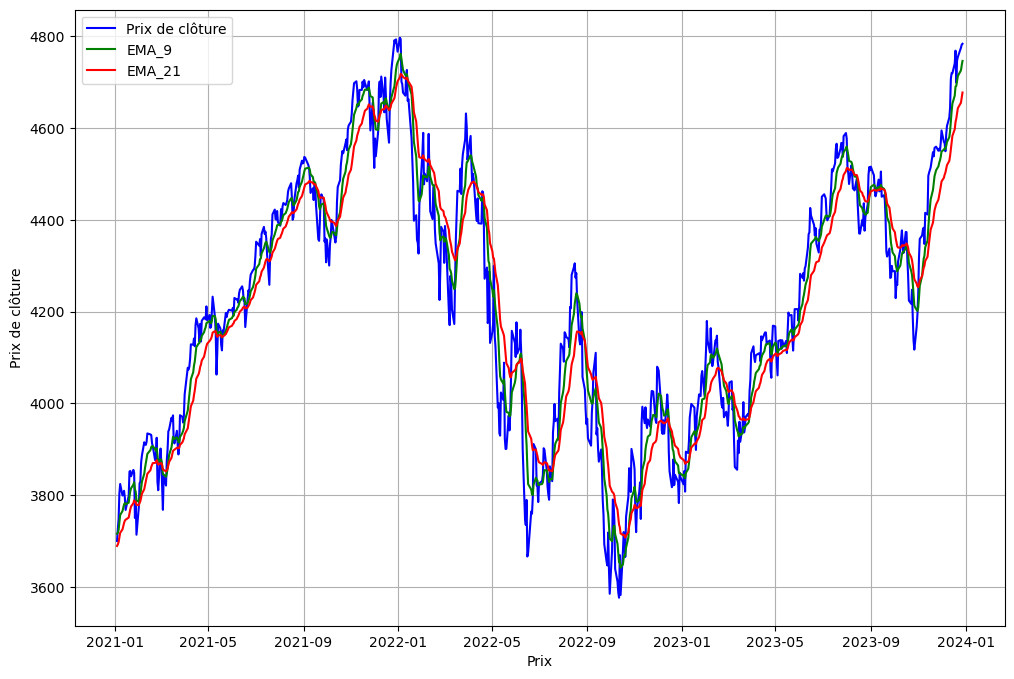

In [40]:
# Choisir sur quelle fenêtre tracer le graphique 
df_filtered = df.loc['2021-01-01':'2023-12-31']

plt.figure(figsize=(12, 8))

plt.plot(df_filtered.index, df_filtered['Close'], label='Prix de clôture', color='blue')
plt.plot(df_filtered.index, df_filtered['EMA_9'], label='EMA_9', color='green')
plt.plot(df_filtered.index, df_filtered['EMA_21'], label='EMA_21', color='red')


plt.ylabel('Prix de clôture')
plt.xlabel('Prix')
plt.grid()
plt.legend()

# Afficher le graphique
plt.show()


MACD : Moving Average Convergence Divergence

explication : https://www.degiro.fr/connaissances/strategies/analyse-technique/indice-macd#:~:text=L'indicateur%20MACD%20est%20un,MACD%20pour%20prendre%20des%20positions.

Interprétation : 

Lorsque la MACD Line croise la Signal Line à la hausse : signal d'achat.
Lorsque la MACD Line croise la Signal Line à la baisse : signal de vente.

HISTOGRAMME : 
Positif : tendance haussière.
Négatif : tendance baissière.

In [42]:
def calculate_macd(data, span_fast=12, span_slow=26, span_signal=9):

    ema_fast = calculate_ema(data, span=span_fast)
    ema_slow = calculate_ema(data, span=span_slow)
    
    macd_line = ema_fast - ema_slow
    
    signal_line = calculate_ema(macd_line, span=span_signal)
    
    histogram = macd_line - signal_line
    
    # Retourner un DataFrame
    return pd.DataFrame({
        'MACD_Line': macd_line,
        'Signal_Line': signal_line,
        'Histogram': histogram
    })

In [43]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'VIX', 'VIX_diff',
       'Treasury_Yield_10y', 'Treasury_Yield_10y_diff', 'Unemployment_Rate',
       'Unemployment_Rate_diff', 'CPI', 'CPI_diff', 'Close J+1', 'Log_Returns',
       'RSI_7', 'RSI_14', 'RSI_21', 'MA_5', 'MA_10', 'MA_20', 'MA_50',
       'MA_200', 'Close_vs_MA_5', 'Close_vs_MA_10', 'Close_vs_MA_20',
       'Close_vs_MA_50', 'Close_vs_MA_200', 'EMA_5', 'EMA_9', 'EMA_21',
       'EMA_50', 'EMA_9_21_diff', 'EMA_9_cross_21'],
      dtype='object', name='Price')

In [44]:
# Modification du dataframe 

MACD_df = calculate_macd(df['Close'], span_fast=12, span_slow=26, span_signal=9)

columns_to_check = ['MACD_Line', 'Signal_Line', 'Histogram']

if any(col in df.columns for col in columns_to_check): 
    df.drop(['MACD_Line', 'Signal_Line', 'Histogram'], axis = 1)
    df = pd.concat([df, MACD_df], axis = 1)
else : 
    df = pd.concat([df, MACD_df], axis = 1)



df.head(5)


,Close,High,Low,Open,Volume,VIX,VIX_diff,Treasury_Yield_10y,Treasury_Yield_10y_diff,Unemployment_Rate,...,Close_vs_MA_200,EMA_5,EMA_9,EMA_21,EMA_50,EMA_9_21_diff,EMA_9_cross_21,MACD_Line,Signal_Line,Histogram
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,19.350000,-0.690001,3.77,-0.08,9.8,...,NaN,1136.520020,1136.520020,1136.520020,1136.520020,0.000000,0,0.000000,0.000000,0.000000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,19.160000,-0.190001,3.85,0.08,9.8,...,NaN,1136.726685,1136.644019,1136.576383,1136.544333,0.067636,1,0.049458,0.009892,0.039567
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,19.059999,-0.100000,3.85,0.00,9.8,...,NaN,1138.381104,1137.653203,1137.041252,1136.746122,0.611951,1,0.450601,0.098034,0.352568
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,18.129999,-0.930000,3.83,-0.02,9.8,...,NaN,1140.580729,1139.118559,1137.762954,1137.069018,1.355604,1,1.022205,0.282868,0.739337
2010-01-11,1146.979980,1149.739990,1142.020020,1145.959961,4255780000,17.549999,-0.580000,3.85,0.02,9.8,...,NaN,1142.713813,1140.690843,1138.600866,1137.457683,2.089977,1,1.617938,0.549882,1.068056


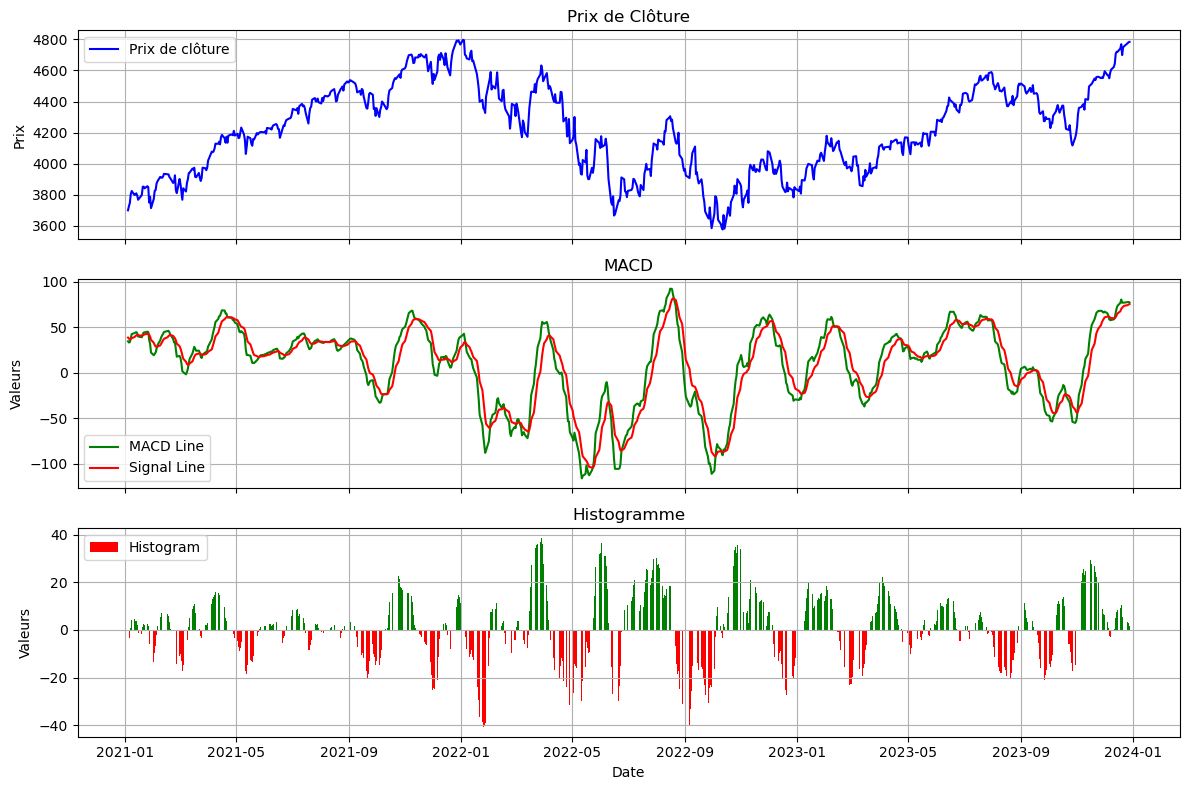

In [45]:
# Filtrer les données
df_filtered = df.loc['2021-01-01':'2023-12-31']

# Créer une figure avec trois sous-graphes alignés horizontalement
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Prix de clôture
ax1.plot(df_filtered.index, df_filtered['Close'], label='Prix de clôture', color='blue')
ax1.set_title('Prix de Clôture')
ax1.set_ylabel('Prix')
ax1.legend()
ax1.grid()

# MACD
ax2.plot(df_filtered.index, df_filtered['MACD_Line'], label='MACD Line', color='green')
ax2.plot(df_filtered.index, df_filtered['Signal_Line'], label='Signal Line', color='red')
ax2.set_title('MACD')
ax2.set_ylabel('Valeurs')
ax2.legend()
ax2.grid()

# Histogramme du MACD
ax3.bar(df_filtered.index, df_filtered['Histogram'], label='Histogram', color=['green' if val >= 0 else 'red' for val in df_filtered['Histogram']])
ax3.set_title('Histogramme')
ax3.set_ylabel('Valeurs')
ax3.legend()
ax3.grid()

# Afficher le graphique
plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [46]:
def calculate_bollinger_bands(df, window=20, num_std=2):
    # Calcul de la Moyenne Mobile Simple (SMA)
    sma = df['Close'].rolling(window=window).mean()

    # Calcul de l'écart-type
    std = df['Close'].rolling(window=window).std()

    # Calcul des bandes de Bollinger
    upper_band = sma + (num_std * std)
    lower_band = sma - (num_std * std)

    bollinger_volatility = upper_band - lower_band


    # Créer un DataFrame avec uniquement les bandes
    bollinger_bands = pd.DataFrame({
        'MA_bollinger_20': sma,
        'Upper_Band': upper_band,
        'Lower_Band': lower_band,
        'Bollinger_volatility': bollinger_volatility

    })
    
    return bollinger_bands



In [47]:
# Modification du dataframe 

bollinger_df = calculate_bollinger_bands(df, window=20, num_std=2)

columns_to_check = ['MA_bollinger_20', 'Upper_Band', 'Lower_Band', 'Bollinger_volatility']

if any(col in df.columns for col in columns_to_check): 
    df.drop(['MA_bollinger_20', 'Upper_Band', 'Lower_Band', 'Bollinger_volatility'], axis = 1)
    df = pd.concat([df, bollinger_df], axis = 1)
else : 
    df = pd.concat([df, bollinger_df], axis = 1)

df['Distance_from_MA'] = (df['Close'] - df['MA_bollinger_20']) / df['MA_bollinger_20']
df['Above_Upper_Band'] = (df['Close'] > df['Upper_Band']).astype(int)
df['Below_Lower_Band'] = (df['Close'] < df['Lower_Band']).astype(int)

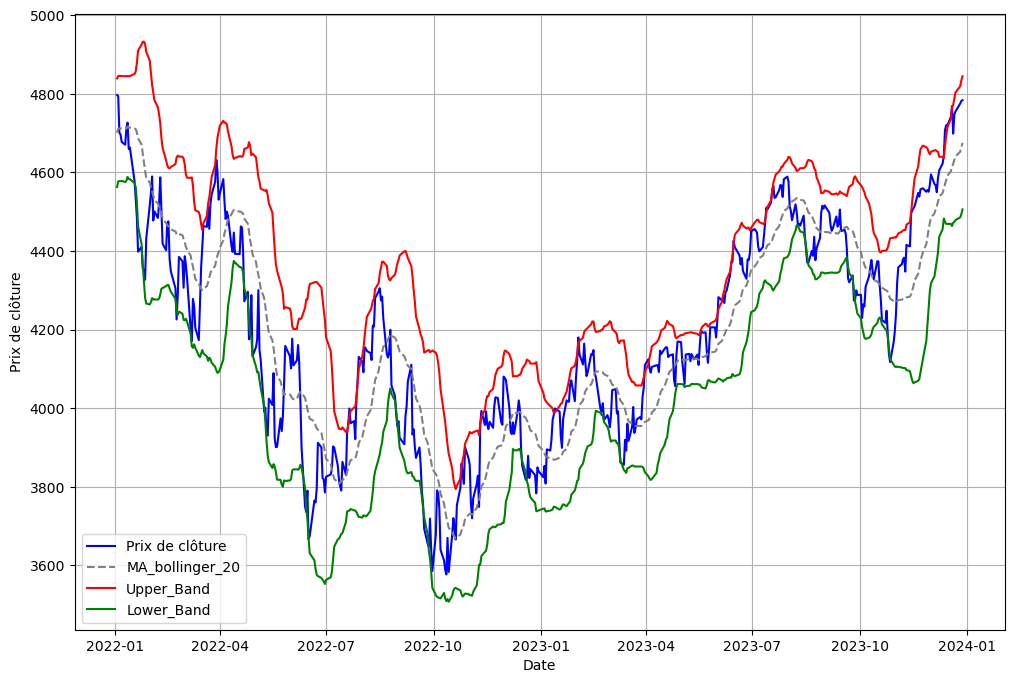

In [48]:
# Visualisation 

df_filtered = df.loc['2022-01-01':'2023-12-31']

plt.figure(figsize=(12, 8))

plt.plot(df_filtered.index, df_filtered['Close'], label='Prix de clôture', color='blue')
plt.plot(df_filtered.index, df_filtered['MA_bollinger_20'],'--', label='MA_bollinger_20', color='gray')
plt.plot(df_filtered.index, df_filtered['Upper_Band'], label='Upper_Band', color='red')
plt.plot(df_filtered.index, df_filtered['Lower_Band'], label='Lower_Band', color='green')

plt.ylabel('Prix de clôture')
plt.xlabel('Date')
plt.grid()
plt.legend()

# Afficher le graphique
plt.show()

In [49]:
df.isnull().sum()

Close                        0
High                         0
Low                          0
Open                         0
Volume                       0
VIX                          0
VIX_diff                     0
Treasury_Yield_10y           0
Treasury_Yield_10y_diff      0
Unemployment_Rate            0
Unemployment_Rate_diff       0
CPI                          0
CPI_diff                     0
Close J+1                    0
Log_Returns                  0
RSI_7                        1
RSI_14                       1
RSI_21                       1
MA_5                         4
MA_10                        9
MA_20                       19
MA_50                       49
MA_200                     199
Close_vs_MA_5                4
Close_vs_MA_10               9
Close_vs_MA_20              19
Close_vs_MA_50              49
Close_vs_MA_200            199
EMA_5                        0
EMA_9                        0
EMA_21                       0
EMA_50                       0
EMA_9_21

In [50]:
df.isna().sum()

Close                        0
High                         0
Low                          0
Open                         0
Volume                       0
VIX                          0
VIX_diff                     0
Treasury_Yield_10y           0
Treasury_Yield_10y_diff      0
Unemployment_Rate            0
Unemployment_Rate_diff       0
CPI                          0
CPI_diff                     0
Close J+1                    0
Log_Returns                  0
RSI_7                        1
RSI_14                       1
RSI_21                       1
MA_5                         4
MA_10                        9
MA_20                       19
MA_50                       49
MA_200                     199
Close_vs_MA_5                4
Close_vs_MA_10               9
Close_vs_MA_20              19
Close_vs_MA_50              49
Close_vs_MA_200            199
EMA_5                        0
EMA_9                        0
EMA_21                       0
EMA_50                       0
EMA_9_21

In [51]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'VIX', 'VIX_diff',
       'Treasury_Yield_10y', 'Treasury_Yield_10y_diff', 'Unemployment_Rate',
       'Unemployment_Rate_diff', 'CPI', 'CPI_diff', 'Close J+1', 'Log_Returns',
       'RSI_7', 'RSI_14', 'RSI_21', 'MA_5', 'MA_10', 'MA_20', 'MA_50',
       'MA_200', 'Close_vs_MA_5', 'Close_vs_MA_10', 'Close_vs_MA_20',
       'Close_vs_MA_50', 'Close_vs_MA_200', 'EMA_5', 'EMA_9', 'EMA_21',
       'EMA_50', 'EMA_9_21_diff', 'EMA_9_cross_21', 'MACD_Line', 'Signal_Line',
       'Histogram', 'MA_bollinger_20', 'Upper_Band', 'Lower_Band',
       'Bollinger_volatility', 'Distance_from_MA', 'Above_Upper_Band',
       'Below_Lower_Band'],
      dtype='object')

In [52]:
df = df.dropna()

## Étude des variables

In [53]:
# Calcul de la corrélation
correlation_matrix = df.corr()

# Trier les corrélations par rapport à Close J+1
target_corr = correlation_matrix['Close J+1'].sort_values(ascending=False)

# Affichage des top 10 et des moins corrélées
print("Corrélation des variables à Close J+1", target_corr)

Corrélation des variables à Close J+1 Close J+1                  1.000000
Close                      0.999553
Low                        0.999461
High                       0.999437
Open                       0.999317
EMA_5                      0.999278
MA_5                       0.999117
EMA_9                      0.998917
MA_10                      0.998520
EMA_21                     0.997889
MA_bollinger_20            0.997279
MA_20                      0.997279
Lower_Band                 0.996700
EMA_50                     0.995899
Upper_Band                 0.994860
MA_50                      0.994360
MA_200                     0.983396
CPI                        0.934682
Bollinger_volatility       0.558963
CPI_diff                   0.459408
Close_vs_MA_200            0.251073
Volume                     0.243180
Close_vs_MA_50             0.140213
Signal_Line                0.139638
MACD_Line                  0.139067
EMA_9_21_diff              0.128430
VIX                       

In [54]:
print(correlation_matrix)

                            Close      High       Low      Open    Volume  \
Close                    1.000000  0.999843  0.999862  0.999708  0.242982   
High                     0.999843  1.000000  0.999777  0.999888  0.249225   
Low                      0.999862  0.999777  1.000000  0.999833  0.237608   
Open                     0.999708  0.999888  0.999833  1.000000  0.244871   
Volume                   0.242982  0.249225  0.237608  0.244871  1.000000   
VIX                      0.125781  0.134532  0.119606  0.129022  0.624276   
VIX_diff                -0.006160  0.003533  0.000526  0.010310  0.072897   
Treasury_Yield_10y       0.113657  0.113318  0.114426  0.113594 -0.173730   
Treasury_Yield_10y_diff  0.031231  0.029005  0.030488  0.027374 -0.024396   
Unemployment_Rate       -0.565474 -0.564762 -0.566548 -0.565744  0.104506   
Unemployment_Rate_diff  -0.036633 -0.035287 -0.038023 -0.036562  0.207274   
CPI                      0.934806  0.935697  0.933924  0.934770  0.242440   

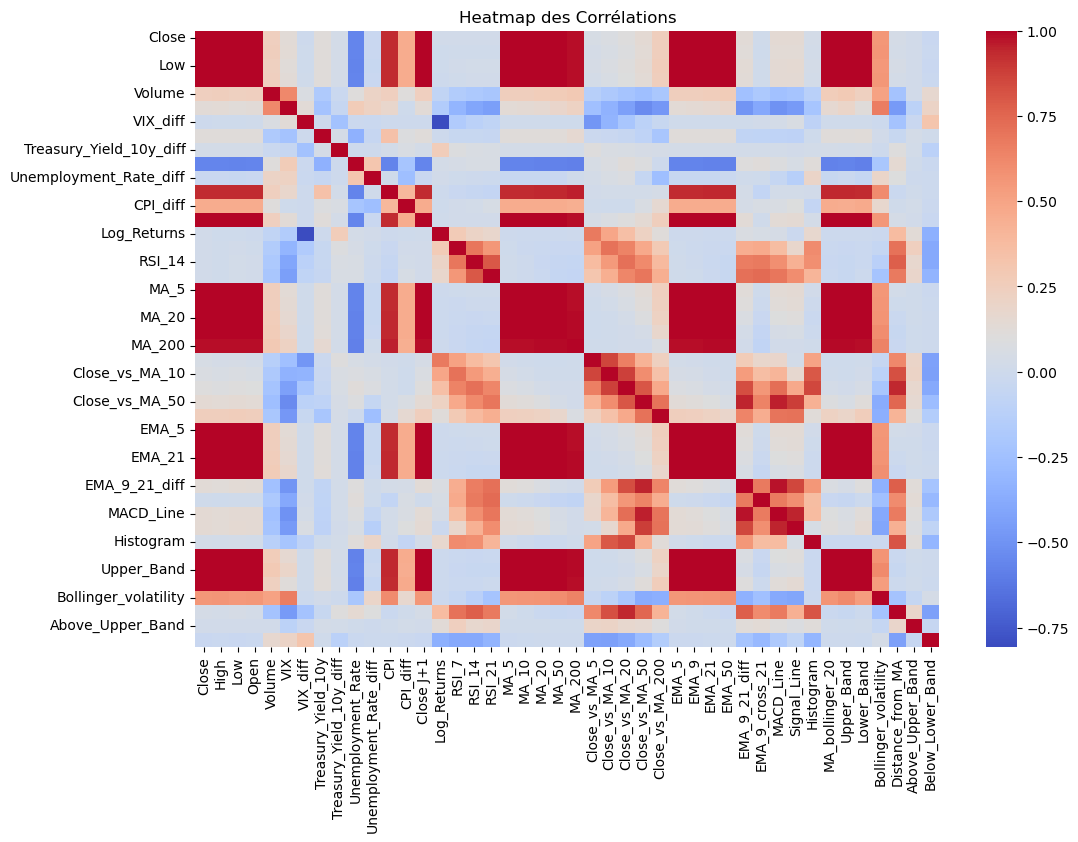

In [62]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Heatmap des Corrélations")
plt.show()

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sélection des features sans la cible
X = df.drop(columns=['Close J+1'])

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage des résultats
print(vif_data.sort_values(by='VIF', ascending=False))

C:\Users\antoi\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                    feature           VIF
0                     Close           inf
18                    MA_10           inf
20                    MA_50           inf
23           Close_vs_MA_10           inf
24           Close_vs_MA_20           inf
25           Close_vs_MA_50           inf
26          Close_vs_MA_200           inf
28                    EMA_9           inf
29                   EMA_21           inf
31            EMA_9_21_diff           inf
33                MACD_Line           inf
34              Signal_Line           inf
35                Histogram           inf
36          MA_bollinger_20           inf
37               Upper_Band           inf
38               Lower_Band           inf
39     Bollinger_volatility           inf
19                    MA_20           inf
21                   MA_200           inf
17                     MA_5           inf
22            Close_vs_MA_5  9.007199e+15
27                    EMA_5  5.252091e+07
30                   EMA_50  4.989

In [66]:
selected_features = [
    'Close', 'MACD_Line', 'Bollinger_volatility', 'Distance_from_MA',
    'Volume', 'RSI_14', 'CPI_diff', 'VIX_diff', 'Unemployment_Rate_diff',
    'Treasury_Yield_10y_diff'
]
df_selected = df[selected_features + ['Close J+1']]

In [68]:
# Sélection des features sans la cible
X = df_selected.drop(columns=['Close J+1'])

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage des résultats
print(vif_data.sort_values(by='VIF', ascending=False))

                   feature        VIF
4                   Volume  17.086621
5                   RSI_14  15.835945
0                    Close  14.216241
2     Bollinger_volatility   5.493725
3         Distance_from_MA   3.132855
1                MACD_Line   2.822538
6                 CPI_diff   2.115283
8   Unemployment_Rate_diff   1.251751
7                 VIX_diff   1.194962
9  Treasury_Yield_10y_diff   1.067096


In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Préparation des données
X = df_selected.drop(columns=['Close J+1'])
y = df_selected['Close J+1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))

                   Feature  Importance
0                    Close    0.999216
4                   Volume    0.000116
2     Bollinger_volatility    0.000116
7                 VIX_diff    0.000102
1                MACD_Line    0.000097
8   Unemployment_Rate_diff    0.000089
3         Distance_from_MA    0.000085
9  Treasury_Yield_10y_diff    0.000065
5                   RSI_14    0.000063
6                 CPI_diff    0.000051


## Modélisation

Mean Absolute Error (MAE): 35.15365570335598
Root Mean Squared Error (RMSE): 46.80974225262909


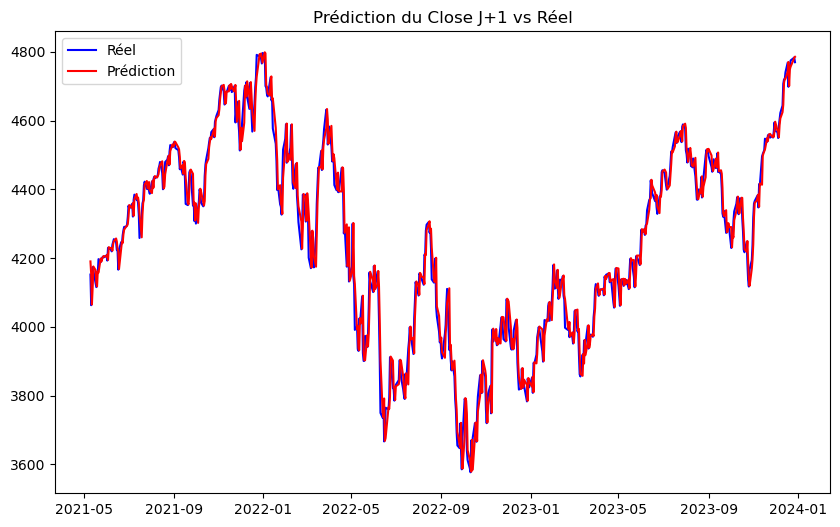

In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. Définir X (features) et y (target)
X = df[['Close']]  # Utilise uniquement la colonne 'Close'
y = df['Close J+1']  # La cible est le 'Close' du jour suivant

# 2. Séparation des données en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Initialiser et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)

# 5. Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 6. Visualisation des prédictions vs réels
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Réel', color='blue')
plt.plot(y_test.index, y_pred, label='Prédiction', color='red')
plt.legend()
plt.title('Prédiction du Close J+1 vs Réel')
plt.show()

résultats mauvais erreur très grande mais modèle naif

Mean Absolute Error (MAE): 35.542932690916516
Root Mean Squared Error (RMSE): 47.19075718529133


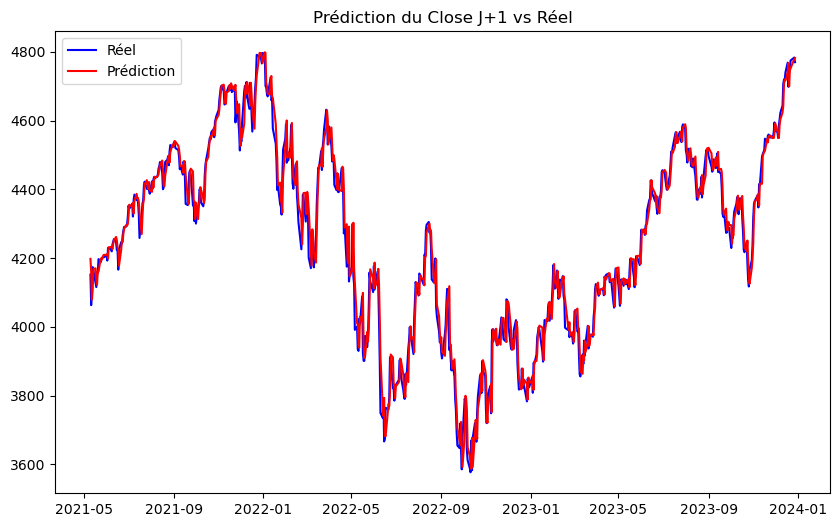

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Sélectionner les variables pour X (features) et y (target)
X = df[['Close', 'Volume', 'RSI_14', 'Bollinger_volatility', 'MACD_Line', 'VIX_diff', 'CPI_diff', 'Distance_from_MA']]
y = df['Close J+1']

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardiser les données (important pour les modèles linéaires)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraîner le modèle
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred = model.predict(X_test_scaled)

# Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 6. Visualisation des prédictions vs réels
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Réel', color='blue')
plt.plot(y_test.index, y_pred, label='Prédiction', color='red')
plt.legend()
plt.title('Prédiction du Close J+1 vs Réel')
plt.show()

empire les choses en ajoutant des variable

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# Sélectionner les variables pour X (features) et y (target)
X = df[['Close']]
y = df['Close J+1']

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer le modèle RandomForest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Évaluer le modèle
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f'Mean Absolute Error (MAE) - Random Forest: {mae_rf}')
print(f'Root Mean Squared Error (RMSE) - Random Forest: {rmse_rf}')

Mean Absolute Error (MAE) - Random Forest: 56.38623127666566
Root Mean Squared Error (RMSE) - Random Forest: 79.12443559338544


In [78]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# Sélectionner les variables pour X (features) et y (target)
X = df[['Close']]
y = df['Close J+1']

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer le modèle XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle
xgb_model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Évaluer le modèle
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f'Mean Absolute Error (MAE) - XGBoost: {mae_xgb}')
print(f'Root Mean Squared Error (RMSE) - XGBoost: {rmse_xgb}')

Mean Absolute Error (MAE) - XGBoost: 62.85284545236212
Root Mean Squared Error (RMSE) - XGBoost: 87.14112762756005


In [80]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

voting_reg = VotingRegressor(estimators=[
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('xgb', xgb.XGBRegressor())
])

voting_reg.fit(X_train_scaled, y_train)
y_pred_voting = voting_reg.predict(X_test_scaled)

mae_voting = mean_absolute_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))
print(f"MAE (Voting): {mae_voting}")
print(f"RMSE (Voting): {rmse_voting}")

MAE (Voting): 48.581835891430266
RMSE (Voting): 64.89686954436961


#### Au vu des mauvaises performances de notre modèle, on va essayer de prédire la direction (haussière ou baissière) du marché

In [82]:
# Ajouter une colonne 'Movement' qui compare 'Close J+1' et 'Close'
df['Movement'] = df['Close J+1'] - df['Close']

# Ajouter une colonne catégorielle 'Direction' pour indiquer le mouvement
# 'Up' si Close J+1 > Close, 'Down' si Close J+1 < Close, 'No Change' sinon
df['Direction'] = df['Movement'].apply(lambda x: 1 if x > 0 else (0 if x <= 0 else 'No Change'))

# Vérification des premières lignes
print(df[['Close', 'Close J+1', 'Movement', 'Direction']].head())

                  Close    Close J+1   Movement  Direction
Date                                                      
2010-10-19  1165.900024  1178.170044  12.270020          1
2010-10-20  1178.170044  1180.260010   2.089966          1
2010-10-21  1180.260010  1183.079956   2.819946          1
2010-10-22  1183.079956  1185.619995   2.540039          1
2010-10-25  1185.619995  1185.640015   0.020020          1


In [84]:
# Calcul de la corrélation
correlation_matrix = df.corr()

# Trier les corrélations par rapport à Close J+1
target_corr = correlation_matrix['Direction'].sort_values(ascending=False)

# Affichage des top 10 et des moins corrélées
print("Corrélation des variables à Direction", target_corr)

Corrélation des variables à Direction Direction                  1.000000
Movement                   0.618378
Unemployment_Rate          0.037257
Below_Lower_Band           0.023560
VIX_diff                   0.019796
VIX                        0.012309
Volume                     0.006240
Close_vs_MA_200            0.004912
Signal_Line                0.001175
Unemployment_Rate_diff    -0.003304
MACD_Line                 -0.003882
Close J+1                 -0.005859
CPI_diff                  -0.006469
EMA_9_21_diff             -0.006765
EMA_9_cross_21            -0.007375
Close_vs_MA_50            -0.010587
Histogram                 -0.015159
RSI_21                    -0.015435
Bollinger_volatility      -0.018557
Close_vs_MA_20            -0.019418
RSI_14                    -0.022025
Lower_Band                -0.022727
RSI_7                     -0.022803
MA_bollinger_20           -0.023134
MA_20                     -0.023134
MA_10                     -0.023266
EMA_21                    

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sélection des features sans la cible
X = df.drop(columns=['Direction','Close J+1','Movement'])

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage des résultats
print(vif_data.sort_values(by='VIF', ascending=False))

C:\Users\antoi\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                    feature           VIF
0                     Close           inf
18                    MA_10           inf
20                    MA_50           inf
23           Close_vs_MA_10           inf
24           Close_vs_MA_20           inf
25           Close_vs_MA_50           inf
26          Close_vs_MA_200           inf
28                    EMA_9           inf
29                   EMA_21           inf
31            EMA_9_21_diff           inf
33                MACD_Line           inf
34              Signal_Line           inf
35                Histogram           inf
36          MA_bollinger_20           inf
37               Upper_Band           inf
38               Lower_Band           inf
39     Bollinger_volatility           inf
19                    MA_20           inf
21                   MA_200           inf
17                     MA_5           inf
22            Close_vs_MA_5  9.007199e+15
27                    EMA_5  5.252091e+07
30                   EMA_50  4.989

In [88]:
selected_features = [
    'Close', 'MACD_Line', 'Bollinger_volatility', 'Distance_from_MA',
    'Volume', 'RSI_14', 'CPI_diff', 'VIX_diff', 'Unemployment_Rate_diff',
    'Treasury_Yield_10y_diff'
]
df_selected = df[selected_features + ['Direction']]

In [90]:
# Sélection des features sans la cible
X = df_selected.drop(columns=['Direction'])

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage des résultats
print(vif_data.sort_values(by='VIF', ascending=False))

                   feature        VIF
4                   Volume  17.086621
5                   RSI_14  15.835945
0                    Close  14.216241
2     Bollinger_volatility   5.493725
3         Distance_from_MA   3.132855
1                MACD_Line   2.822538
6                 CPI_diff   2.115283
8   Unemployment_Rate_diff   1.251751
7                 VIX_diff   1.194962
9  Treasury_Yield_10y_diff   1.067096


In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Préparation des données
X = df_selected.drop(columns=['Direction'])
y = df_selected['Direction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Importance des features
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))

                   Feature  Importance
5                   RSI_14    0.124369
7                 VIX_diff    0.124132
4                   Volume    0.119344
0                    Close    0.115459
2     Bollinger_volatility    0.109706
3         Distance_from_MA    0.108836
1                MACD_Line    0.105471
9  Treasury_Yield_10y_diff    0.081359
6                 CPI_diff    0.070867
8   Unemployment_Rate_diff    0.040456


In [120]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# 1. Définir X (features) et y (target)
X = df[['Close']]  # Utilise uniquement la colonne 'Close'
y = df['Direction']  # La cible est le 'Close' du jour suivant

# 2. Séparation des données en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Initialiser et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Prédire les valeurs sur l'ensemble de test
y_pred = model.predict(X_test)

# 6. Convertir les prédictions en catégories
y_pred_categories = np.where(y_pred > 0.5, 1, 0) 
# 7. Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred_categories)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Accuracy: {accuracy:.2f}')

Mean Absolute Error (MAE): 0.4990237324583611
Root Mean Squared Error (RMSE): 0.5015320254420413
Accuracy: 0.51


In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Sélectionner les variables pour X (features) et y (target)
X = df[['Close', 'Volume', 'RSI_14', 'Bollinger_volatility', 'MACD_Line', 'VIX_diff', 'CPI_diff', 'Distance_from_MA']]
y = df['Direction']

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardiser les données (important pour les modèles linéaires)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraîner le modèle
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred = model.predict(X_test_scaled)

# 6. Convertir les prédictions en catégories
y_pred_categories = np.where(y_pred > 0.5, 1, 0) 

# 7. Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred_categories)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Accuracy: {accuracy:.2f}')

Mean Absolute Error (MAE): 0.49996676392053147
Root Mean Squared Error (RMSE): 0.5067053350258347
Accuracy: 0.51


In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler

# Sélectionner les variables pour X (features) et y (target)
X = df[['Close', 'Volume', 'RSI_14', 'Bollinger_volatility', 'MACD_Line', 'VIX_diff', 'CPI_diff', 'Distance_from_MA']]
y = df['Direction']

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Créer le modèle RandomForest
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred_rf = rf_model.predict(X_test_scaled)

# 6. Convertir les prédictions en catégories
y_pred_categories = np.where(y_pred_rf > 0.5, 1, 0) 

# 7. Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
accuracy = accuracy_score(y_test, y_pred_categories)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Accuracy: {accuracy:.2f}')

NameError: name 'df' is not defined